# Goal

The purpose of this notebook is to compare the potential intensity values calculated with and without dissipative heating in pyPI. [Bister and Emanuel (1998)](https://link.springer.com/article/10.1007/BF01030791) estimate that this heating increases potential intensity by 20-25%.

### Setup

In [1]:
import sys
sys.path.append(sys.path[0]+'/..')
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import time
# load PI calculation module
from tcpyPI import pi
# imports utility functions
from tcpyPI.utilities import *

In [2]:
# change default figure font settings
font = {'family' : 'sans-serif',
        'weight' : 1,
        'size'   : 16}

matplotlib.rc('font', **font)

# Load Data

In [3]:
# data location
data_loc='../data/sample_data.nc'
ds=xr.open_dataset(data_loc)

# Calculate PI with and without dissipative heating

We keep other parameters constant while testing the dissipative heating, only altering the dissipating heating flag itself. Ascent is assumed to be reversible, and the CKCD ratio is fixed at 0.9.

In [4]:
# define the flags with and without dissipative heating
dh_on=1
dh_off=0

In [5]:
# create a function to calculate PI over the sample dataset using xarray
def run_sample_dissipation(fn, diss_flag_in, dim='p'):
    
    # open the sample data file
    ds = xr.open_dataset(fn)
    # calculate PI over the whole data set using the xarray universal function
    result = xr.apply_ufunc(
        pi,
        ds['sst'], ds['msl'], ds['p'], ds['t'], ds['q'],
        kwargs=dict(CKCD=0.9,ascent_flag=0, diss_flag=diss_flag_in, V_reduc=0.8,ptop=50,miss_handle=1),
        input_core_dims=[
            [], [], ['p', ], ['p', ], ['p', ],
        ],
        output_core_dims=[
            [], [], [], [], []
        ],
        vectorize=True
    )

    vmax, pmin, ifl, t0, otl = result
    
    out_ds=xr.Dataset({
        'vmax': vmax
    })
    
    # add names and units
    out_ds.vmax.attrs['standard_name'],out_ds.vmax.attrs['units']='Maximum Potential Intensity','m/s'

    # return the output as an xarray data structure
    return out_ds

In [6]:
# calculate PI with dissipative heating
pi_dh_on=run_sample_dissipation(data_loc,dh_on)
# and without dissipative heating
pi_dh_off=run_sample_dissipation(data_loc,dh_off)

# Plot the Results

## Maps

/Users/dgilford/opt/anaconda3/envs/test/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


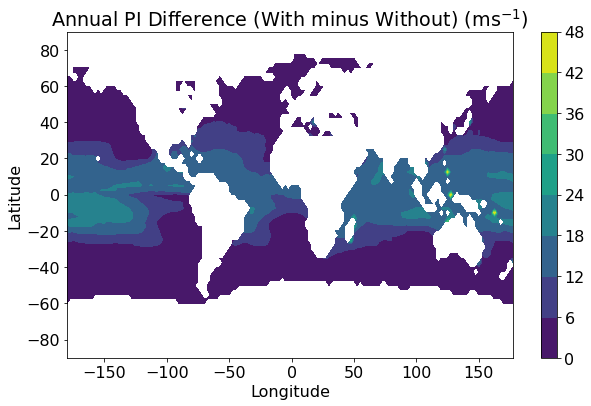

In [7]:
plt.figure(figsize=(10,6))
plt.contourf(ds.lon,ds.lat,pi_dh_on.vmax.mean(dim=['month'])-pi_dh_off.vmax.mean(dim=['month']))
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('Annual PI Difference (With minus Without) (ms$^{-1}$)')
plt.colorbar()
plt.show()

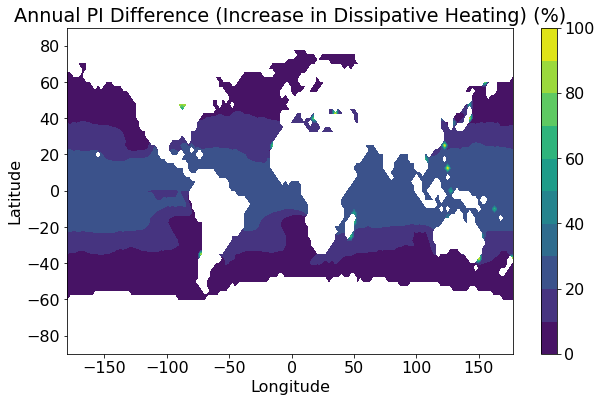

In [8]:
plt.figure(figsize=(10,6))
clevels=np.arange(0,101,10)
plt.contourf(ds.lon,ds.lat, \
             (pi_dh_on.vmax.mean(dim=['month'])-pi_dh_off.vmax.mean(dim=['month']))/pi_dh_on.vmax.mean(dim=['month'])*100, \
            levels=clevels)
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('Annual PI Difference (Increase in Dissipative Heating) (%)')
plt.colorbar()
plt.show()

## Scatter Plots

### All values

In [9]:
# capture all of the values we calculated
on_array=pi_dh_on.vmax.values.flatten()
off_array=pi_dh_off.vmax.values.flatten()
# find where we have valid calculations (non-Na)
idx= np.isfinite(on_array) & np.isfinite(off_array)

In [10]:
# fit a curve to ALL the values, calculate the slope and correlation
zall = np.polyfit(off_array[idx],on_array[idx], 1)
pall = np.poly1d(zall)
x = np.linspace(0, 125, 1000)
R=np.corrcoef(off_array[idx],on_array[idx])
print('Slope (With/Without) == '+str(zall[0]))
print('R^2 == '+str(R[0,1]**2))

Slope (With/Without) == 1.3371258884878698
R^2 == 0.9952124814613625


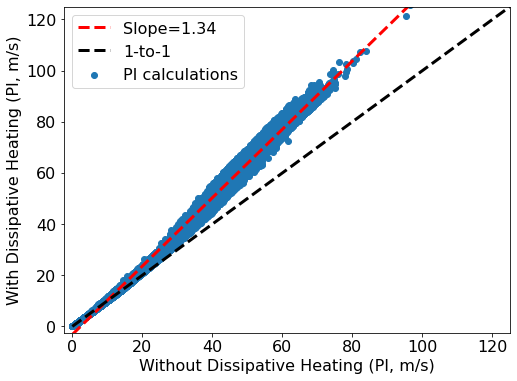

In [11]:
# plot the result
plt.figure(figsize=(8,6))
plt.scatter(off_array[idx],on_array[idx],label='PI calculations')
plt.plot(x,pall(x),'--r',lw=3,label='Slope='+str(round(zall[0],2)))

plt.xlabel('Without Dissipative Heating (PI, m/s)')
plt.ylabel('With Dissipative Heating (PI, m/s)')
plt.xlim([-2.5,125])
plt.ylim([-2.5,125])
plt.plot([0,125],[0,125],'k--',lw=3,label='1-to-1')

plt.legend(loc='best')

plt.show()

So that (over all values) for every 1 m/s increase in PI without dissipative heating, the PI with dissipative heating increases by 1.34 m/s.

We notice from the maps above that the largest percent differences between the PI calculations with and without dissipative heating seem to occur in the regions where SSTs are warm and PIs are high, but this could be an artifact of the countour plot. This maybe should have been seen in the above the scatter plot with all values, where a linear model works well. Are there some non-linearities underlying the results?

To test this, we check the warmest profiles:

### Warm SSTs (> 25$^{\circ}$C)

Here we estimate the slope between PI calculations with/without dissipative heating for profiles that have warm SSTs. Here we define warm as ~exceeding 25 degrees Celsius.

In [23]:
sst_warm=ds.sst.values.flatten()
idsst= np.isfinite(on_array) & np.isfinite(off_array) & np.isfinite(sst_warm)

In [56]:
# define the warm threshold
threshC=25
# find the locations and subset the indices which are both warm and valid
warmi=np.argwhere(sst_warm >= threshC)
idxwarm=np.intersect1d(warmi,np.argwhere(idsst==True))

/Users/dgilford/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.


In [57]:
# fit a curve to the WARM values, calculate the slope and correlation
zwarm = np.polyfit(off_array[idxwarm],on_array[idxwarm], 1)
pwarm = np.poly1d(zwarm)
R=np.corrcoef(off_array[idxwarm],on_array[idxwarm])
print('Slope (With/Without) == '+str(zwarm[0]))
print('R^2 == '+str(R[0,1]**2))

Slope (With/Without) == 1.2675562211732267
R^2 == 0.9731345078234561


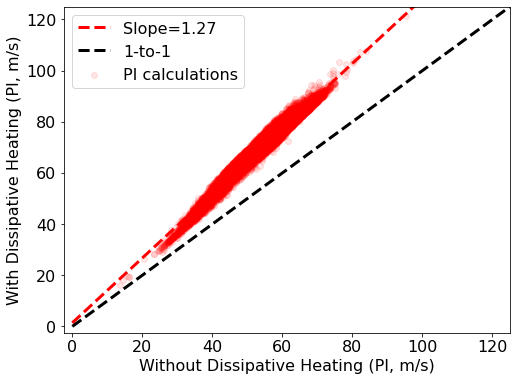

In [58]:
# plot the result
plt.figure(figsize=(8,6))
plt.scatter(off_array[idxwarm],on_array[idxwarm],FaceColor='r',alpha=0.1,label='PI calculations')
plt.plot(x,pwarm(x),'--r',lw=3,label='Slope='+str(round(zwarm[0],2)))

plt.xlabel('Without Dissipative Heating (PI, m/s)')
plt.ylabel('With Dissipative Heating (PI, m/s)')
plt.xlim([-2.5,125])
plt.ylim([-2.5,125])
plt.plot([0,125],[0,125],'k--',lw=3,label='1-to-1')

plt.legend(loc='best')

plt.show()

The result is relatively robust to the SST threshold (with slopes between 1.27 and 1.37 over 20-30C), suggesting that we can have confidence that in dissipative heating PI exceeding PI without dissipative heating by about the same amount wherever PI calculations are valid.

As SSTs drop below 20C, the slopes near 1.0: dissipative heating is less important for PI with cooler SSTs. Is this related to storm strength? We explore that next...

### Lower PI

Subsetting PI values by tropical storm strength (32 m/s) in non-dissipative heating results yields two populations:

In [61]:
# define the tropical storm threshold
threshTS=32
# find the locations and subset the indices which are both warm and valid
belowTSi=np.argwhere(off_array < threshTS)
aboveTSi=np.argwhere(off_array >= threshTS)
idxbelowTS=np.intersect1d(belowTSi,np.argwhere(idx==True))
idxaboveTS=np.intersect1d(aboveTSi,np.argwhere(idx==True))

/Users/dgilford/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/Users/dgilford/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """


In [64]:
# fit a curve to the BELOW and ABOVE values, calculate the slope and correlation
zbelow = np.polyfit(off_array[idxbelowTS],on_array[idxbelowTS], 1)
pbelow = np.poly1d(zbelow)
R=np.corrcoef(off_array[idxbelowTS],on_array[idxbelowTS])
print('BELOW TS, Slope (With/Without) == '+str(zbelow[0]))
print('BELOW TS, R^2 == '+str(R[0,1]**2))

zabove = np.polyfit(off_array[idxaboveTS],on_array[idxaboveTS], 1)
pabove = np.poly1d(zabove)
R=np.corrcoef(off_array[idxaboveTS],on_array[idxaboveTS])
print('ABOVE TS, Slope (With/Without) == '+str(zabove[0]))
print('ABOVE TS, R^2 == '+str(R[0,1]**2))

BELOW TS, Slope (With/Without) == 1.1741483578249088
BELOW TS, R^2 == 0.9944954008563973
ABOVE TS, Slope (With/Without) == 1.3561202262898768
ABOVE TS, R^2 == 0.9739940902446553


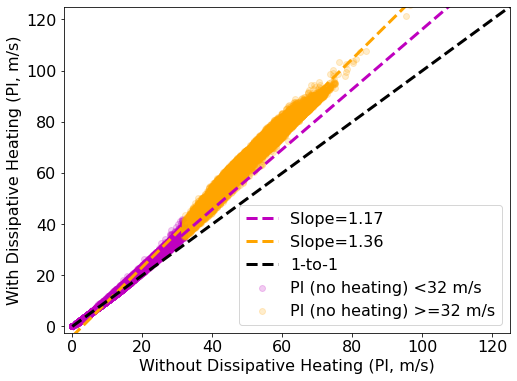

In [67]:
# plot the result
plt.figure(figsize=(8,6))

plt.scatter(off_array[idxbelowTS],on_array[idxbelowTS],FaceColor='m',alpha=0.2,label='PI (no heating) <32 m/s')
plt.plot(x,pbelow(x),'--m',lw=3,label='Slope='+str(round(zbelow[0],2)))

plt.scatter(off_array[idxaboveTS],on_array[idxaboveTS],FaceColor='orange',alpha=0.2,label='PI (no heating) >=32 m/s')
plt.plot(x,pabove(x),'--',c='orange',lw=3,label='Slope='+str(round(zabove[0],2)))

plt.xlabel('Without Dissipative Heating (PI, m/s)')
plt.ylabel('With Dissipative Heating (PI, m/s)')
plt.xlim([-2.5,125])
plt.ylim([-2.5,125])
plt.plot([0,125],[0,125],'k--',lw=3,label='1-to-1')

plt.legend(loc='best')

plt.show()

## Percent Difference

Let's find the straight percent differences between the PI values with and without dissipative heating, as a function of PI (without it):

In [96]:
# define the percent difference formula
def mean_perc_diff(x,y):
    num=np.abs(x.mean()-y.mean())
    den=(x.mean()+y.mean())/2
    return(num/den*100)

In [99]:
# loop over PI values and calculate the slopes and percent differences
pi_mid=np.arange(5,85+1,10)

# initialize arrays
slopes=np.empty((len(pi_mid),))
percdiff=np.empty((len(pi_mid),))
nprof=np.empty((len(pi_mid),))

for k in range(len(pi_mid)):
    
    # find all the values in the bins
    binsi_below=np.argwhere(off_array>=pi_mid[k]-5)
    binsi_above=np.argwhere(off_array<pi_mid[k]+5)
    binsi=np.intersect1d(binsi_below,binsi_above)
    idxbins=np.intersect1d(binsi,np.argwhere(idx==True))
    
    # store the number of profiles in this bin
    nprof[k,]=len(idxbins)
    
    # calculate and store the slopes
    zbins = np.polyfit(off_array[idxbins],on_array[idxbins], 1)
    slopes[k,]=zbins[0]
    
    # calculate and store the percent differences
    pcdiff_out=mean_perc_diff(off_array[idxbins],on_array[idxbins])
    percdiff[k,]=pcdiff_out

/Users/dgilford/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater_equal
  if sys.path[0] == '':
/Users/dgilford/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]


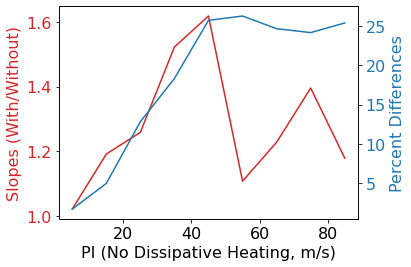

In [98]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('PI (No Dissipative Heating, m/s)')
ax1.set_ylabel('Slopes (With/Without)', color=color)
ax1.plot(pi_mid,slopes, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Percent Differences', color=color)
ax2.plot(pi_mid,percdiff, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

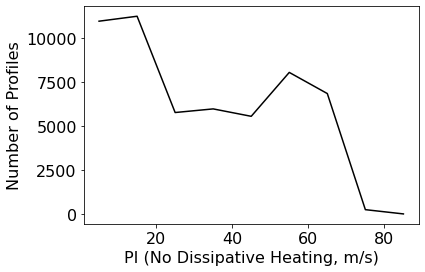

In [103]:
plt.plot(pi_mid,nprof,'k')
plt.xlabel('PI (No Dissipative Heating, m/s)')
plt.ylabel('Number of Profiles')
plt.show()

The lack of consistency between the number of profiles used to calculate the slopes and the variance of the slope itself gives pause as to why there is some non-linearity around 50 m/s (when profile counts are still relatively high). This deserves further investigation.

In any case, it is safe to assume that the percent differences of PI calculations (that land above 40 m/s), between those which have dissipative heating and those which do not, is ~25%.